In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [2]:
#num_points_per_source = 5000   #num_sources = 20 #epoch = 5000 #sin activation function
# Neural network with fixed sine activation

In [3]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [4]:
# Domain parameters
x_min, x_max = 0.0, 4.0  # km
y_min, y_max = 0.0, 4.0  # km
z_min, z_max = 0.0, 4.0  # km
dx, dy, dz = 0.04, 0.04, 0.04  # km (40m)
nx, ny, nz = 101, 101, 101  # grid points
source_x, source_z = 1.0, 1.0  # km

# Velocity model parameters
v0 = 2.0  # km/s at surface
vertgrad = 0.25   # s^{-1}
horigrad = 0.0

num_sources = 20
sources = torch.rand(num_sources, 3) * torch.tensor([[x_max - x_min, y_max - y_min, z_max - z_min]]) + torch.tensor([[x_min, y_min, z_min]])
sources = sources.to(device)

# Generate 3D grid coordinates
x = torch.linspace(x_min, x_max, nx, device=device)
y = torch.linspace(y_min, y_max, ny, device=device)
z = torch.linspace(z_min, z_max, nz, device=device)
X, Y, Z = torch.meshgrid(x, y, z, indexing='ij')
coords = torch.stack((X.flatten(), Y.flatten(), Z.flatten()), dim=1)

v_ref = v0 + vertgrad * source_z + horigrad* source_x

# Velocity model (vertically varying)
velmodel = v0 + vertgrad * Z  # v0=2.0 km/s at surface


In [5]:
# Traveltime solution
if vertgrad==0 and horigrad==0: 
  # For homogeneous velocity model
  T_data = np.sqrt((Z-sz)**2 + (X-sx)**2)/v0;
else: 
  # For velocity gradient model
  T_data = torch.arccosh(1.0+0.5*(1.0/velmodel)*(1/v_ref)*(vertgrad**2 + horigrad**2)*((X-source_x)**2 + (Z-source_z)**2))/np.sqrt(vertgrad**2 + horigrad**2)

In [6]:
def print_source_coordinates(sources):
    """
    Print coordinates of randomly generated sources
    
    Args:
        sources: Tensor of source coordinates with shape (num_sources, 3)
    """
    print("\nRandomly generated source coordinates:")
    print(f"{'Index':<8} {'X (km)':<10} {'Y (km)':<10} {'Z (km)':<10}")
    print("-" * 40)
    for i, src in enumerate(sources):
        print(f"{i:<8} {src[0].item():<10.4f} {src[1].item():<10.4f} {src[2].item():<10.4f}")

print_source_coordinates(sources)


Randomly generated source coordinates:
Index    X (km)     Y (km)     Z (km)    
----------------------------------------
0        3.5291     3.6600     1.5315    
1        3.8372     1.5618     2.4036    
2        1.0263     3.1746     3.7631    
3        0.5327     3.7384     2.3743    
4        3.4776     2.2709     2.9644    
5        1.7176     3.5418     2.2956    
6        1.0663     2.5098     1.0785    
7        1.7655     1.1877     3.3267    
8        0.4213     1.0780     1.4353    
9        0.7975     2.1888     0.0246    
10       3.8062     0.3011     3.5441    
11       2.3328     1.3506     3.2359    
12       2.3117     3.6159     2.2186    
13       1.3693     2.5374     1.4576    
14       2.8417     3.7856     3.1561    
15       1.1257     3.1545     2.3579    
16       3.0157     0.7810     0.0202    
17       1.2273     0.4660     3.6411    
18       2.5761     2.8284     2.6325    
19       1.9652     3.5652     0.5790    


In [7]:
# Analytical solution for reference traveltime field T0
def calculate_T0(x, y, z, xs, ys, zs, v_ref):
    r = torch.sqrt((x - xs)**2 + (y - ys)**2 + (z - zs)**2)
    return r / v_ref

src0 = sources[0]  # First source
v_ref0 = v0 + vertgrad * src0[2]
T0_full = calculate_T0(X, Y, Z, src0[0], src0[1], src0[2], v_ref0)

def analytical_traveltime(x, y, z, xs, ys, zs, v0, grad):
    dx = x - xs
    dy = y - ys
    dz = z - zs
    r = torch.sqrt(dx**2 + dy**2 + dz**2 + 1e-8)
    
    if grad == 0:
        return r / v0
    else:
        v_ref = v0 + grad * zs
        v_z = v0 + grad * z
        arg = 1 + (grad**2 * r**2) / (2 * v_ref * v_z + 1e-8)
        arg = torch.clamp(arg, min=1.0+1e-8)
        return (1/grad) * torch.arccosh(arg)
    
# Sample training points (include sources)
train_coords = []
T0_train = []
velocity_train = []
num_points_per_source = 5000  # Number of points per source
bc_batch_size = 20          # Boundary condition batch size; set equal to source points

for src in sources:
    # Sample points around each source
    idx = torch.randperm(coords.shape[0])[:num_points_per_source]
    pts = coords[idx]
    
    # Create input: [x,y,z, xs,ys,zs]
    src_rep = src.repeat(pts.size(0), 1)
    input_pts = torch.cat([pts, src_rep], dim=1)
    
    # Compute reference values
    v_ref = v0 + vertgrad * src[2]
    T0_vals = calculate_T0(pts[:,0], pts[:,1], pts[:,2], 
                          src[0], src[1], src[2], v_ref)
    
    train_coords.append(input_pts)
    T0_train.append(T0_vals)
    velocity_train.append(velmodel.flatten()[idx])

# Concatenate all data
train_coords = torch.cat(train_coords)
T0_train = torch.cat(T0_train).unsqueeze(1)
velocity_train = torch.cat(velocity_train).unsqueeze(1)


In [8]:
# Ensure all tensors are on device:
sources = sources.to(device)
coords = coords.to(device)
# Add to training data generation:
train_coords = train_coords.to(device)
T0_train = T0_train.to(device)
velocity_train = velocity_train.to(device)

In [9]:
# Neural network with fixed sine activation
import math 

class SineActivation(nn.Module):
    def __init__(self, n_layers, n_neurons, omega_0=30.0):
        super().__init__()
        self.layers = nn.ModuleList()
        self.omega_0 = omega_0
        
        # Input layer
        self.layers.append(nn.Linear(6, n_neurons))
        self._init_layer(self.layers[-1], 6)
        
        # Hidden layers
        for _ in range(n_layers - 2):  # -2 for input/output layers
            self.layers.append(nn.Linear(n_neurons, n_neurons))
            self._init_layer(self.layers[-1], n_neurons)
        
        # Output layer
        self.output = nn.Linear(n_neurons, 1)
        nn.init.xavier_uniform_(self.output.weight)
        self.output.bias.data.fill_(0.0)
    
    def _init_layer(self, layer, input_dim):
        """SIREN-inspired initialization with omega_0 scaling"""
        bound = math.sqrt(6.0 / input_dim) / self.omega_0
        nn.init.uniform_(layer.weight, -bound, bound)
        nn.init.uniform_(layer.bias, -bound, bound)
    
    def forward(self, x):
        for layer in self.layers:
            x = torch.sin(layer(x))  # Fixed sine activation
        return torch.exp(self.output(x))  # Ensure positive output

In [10]:
# Physics-Informed Neural Network
class PINN:
    def __init__(self):
        self.net = SineActivation(n_layers=8, n_neurons=32).to(device)
        
        # Physics-informed loss weights
        self.lambda_pde = nn.Parameter(torch.tensor(1.0))
        self.lambda_bc = nn.Parameter(torch.tensor(1.0))
        
        # Optimizer with single learning rate
        self.optimizer = optim.Adam(
            [{'params': self.net.parameters()},
             {'params': [self.lambda_pde, self.lambda_bc]}],
            lr=0.0005
        )
        self.loss_history = []
    
    
    def compute_gradients(self, u, x):
        grad_u = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            create_graph=True,
            retain_graph=True
        )[0]
        return grad_u
    
    def physics_loss(self, coords, T0_vals, v_vals):
        coords.requires_grad_(True)
        u = self.net(coords)
        grad_u = self.compute_gradients(u, coords)[:, :3]  # Only spatial gradients
        v_ref = v0 + vertgrad * coords[:,5]  # Source z-coordinate
        
        # Extract source positions (last 3 elements)
        sx, sy, sz = coords[:,3], coords[:,4], coords[:,5]
        
        # Compute position differences
        dx = coords[:,0] - sx
        dy = coords[:,1] - sy
        dz = coords[:,2] - sz
        r = torch.sqrt(dx**2 + dy**2 + dz**2 + 1e-8)
        
        # Compute T0 gradients
        T0_x = dx / (r * v_ref)
        T0_y = dy / (r * v_ref)
        T0_z = dz / (r * v_ref)
        
        # Factored Eikonal terms
        term_x = u * T0_x + T0_vals * grad_u[:,0]
        term_y = u * T0_y + T0_vals * grad_u[:,1]
        term_z = u * T0_z + T0_vals * grad_u[:,2]
        
        pde_residual = term_x**2 + term_y**2 + term_z**2 - (1 / v_vals)**2
        return torch.mean(pde_residual**2)
        
    def boundary_loss(self, source_coords):
        # Create input: [xs,ys,zs, xs,ys,zs]
        input_coords = torch.cat([source_coords, source_coords], dim=1)
        u_pred = self.net(input_coords)
        return torch.mean((u_pred - 1.0)**2)
    
    def train(self, coords, T0_vals, v_vals, sources, epochs):
        # Create DataLoader if using batching
        dataset = TensorDataset(coords, T0_vals, v_vals)
        dataloader = DataLoader(dataset, batch_size=1024, shuffle=True)
        
        for epoch in range(epochs):
            epoch_loss = 0.0  # Initialize epoch loss
            self.optimizer.zero_grad()
            
            # If using DataLoader (batched training):
            for batch_coords, batch_T0, batch_v in dataloader:
                # Calculate loss for this batch
                loss_pde = self.physics_loss(batch_coords, batch_T0, batch_v)
                
                # Sample random sources for BC
                src_idx = torch.randint(0, len(sources), (bc_batch_size,))
                bc_coords = sources[src_idx]
                loss_bc = self.boundary_loss(bc_coords)
                
                total_loss = self.lambda_pde.exp()*loss_pde + \
                            self.lambda_bc.exp()*loss_bc
                total_loss.backward()
                self.optimizer.step()
                epoch_loss += total_loss.item()
                
            # Store and print loss
            avg_loss = epoch_loss / len(dataloader)  # For batched training
            self.loss_history.append(avg_loss)
            if epoch % 100 == 0:
                print(f"Epoch {epoch}/{epochs}, Loss: {avg_loss:.6f}")
                
    def predict(self, coords):
        with torch.no_grad():
            return self.net(coords)


In [11]:
import time
start_time = time.time()

# Initialize and train PINN
pinn = PINN()
pinn.train(train_coords, T0_train, velocity_train, sources, epochs=5000)

elapsed = time.time() - start_time
print('Training time: %.2f minutes' %(elapsed/60.))

Epoch 0/5000, Loss: 0.013154
Epoch 100/5000, Loss: 0.002015
Epoch 200/5000, Loss: 0.000241
Epoch 300/5000, Loss: 0.000017
Epoch 400/5000, Loss: 0.000008
Epoch 500/5000, Loss: 0.000000
Epoch 600/5000, Loss: 0.000000
Epoch 700/5000, Loss: 0.000000
Epoch 800/5000, Loss: 0.000000
Epoch 900/5000, Loss: 0.000000
Epoch 1000/5000, Loss: 0.000000
Epoch 1100/5000, Loss: 0.000000
Epoch 1200/5000, Loss: 0.000000
Epoch 1300/5000, Loss: 0.000000
Epoch 1400/5000, Loss: 0.000000
Epoch 1500/5000, Loss: 0.000000
Epoch 1600/5000, Loss: 0.000000
Epoch 1700/5000, Loss: 0.000000
Epoch 1800/5000, Loss: 0.000000
Epoch 1900/5000, Loss: 0.000000
Epoch 2000/5000, Loss: 0.000000
Epoch 2100/5000, Loss: 0.000000
Epoch 2200/5000, Loss: 0.000000
Epoch 2300/5000, Loss: 0.000000
Epoch 2400/5000, Loss: 0.000000
Epoch 2500/5000, Loss: 0.000000
Epoch 2600/5000, Loss: 0.000000
Epoch 2700/5000, Loss: 0.000000
Epoch 2800/5000, Loss: 0.000000
Epoch 2900/5000, Loss: 0.000000
Epoch 3000/5000, Loss: 0.000000
Epoch 3100/5000, Los

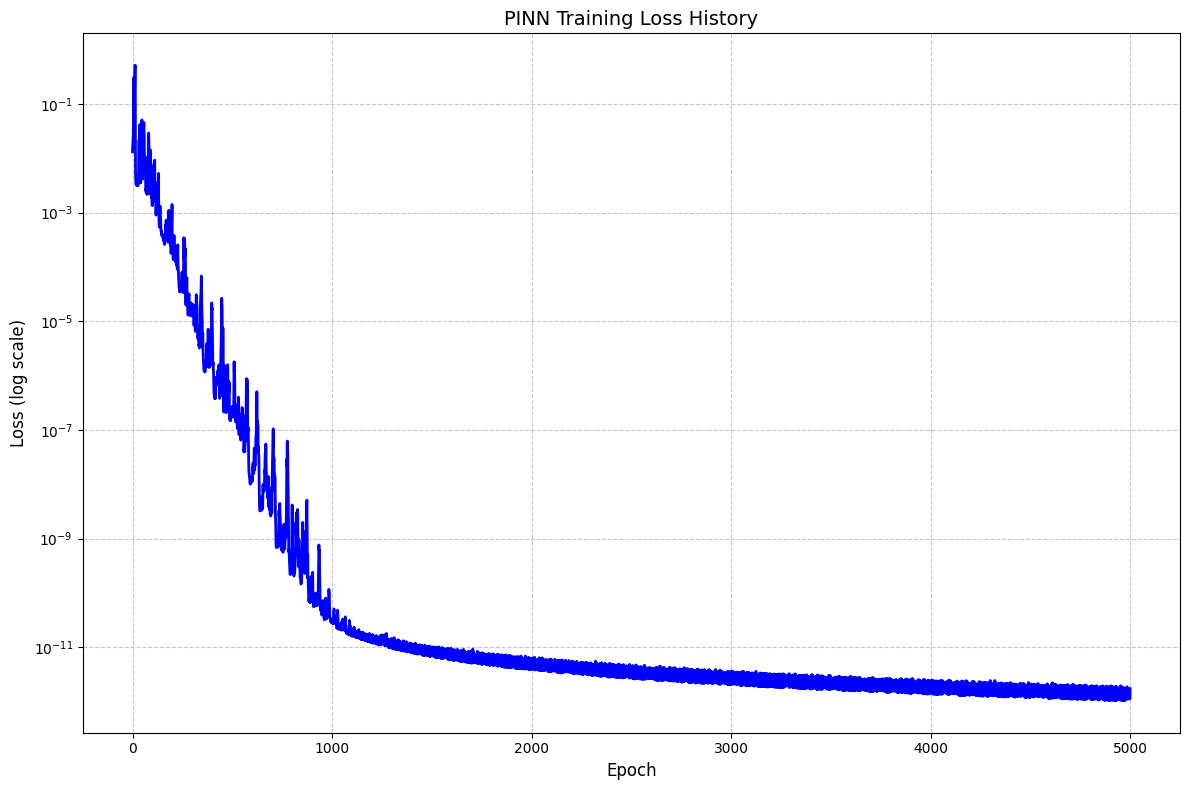


Training Loss Analysis:
- First epoch loss: 1.3154e-02
- Final epoch loss: 1.7276e-12
- Average last 100 epochs: 1.4356e-12
- Total reduction: 7614174340.5x


In [12]:
# Plot training loss history
plt.figure(figsize=(12, 8))

# Main loss plot (log scale)
plt.semilogy(pinn.loss_history, 'b-', linewidth=2, label='Training Loss')
plt.title('PINN Training Loss History', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (log scale)', fontsize=12)
plt.grid(True, which='both', linestyle='--', alpha=0.7)


plt.tight_layout()
plt.savefig('pinn_training_loss.png', dpi=300, bbox_inches='tight')
plt.show()

# Print quantitative analysis
print("\nTraining Loss Analysis:")
print(f"- First epoch loss: {pinn.loss_history[0]:.4e}")
print(f"- Final epoch loss: {pinn.loss_history[-1]:.4e}")
print(f"- Average last 100 epochs: {np.mean(pinn.loss_history[-100:]):.4e}")
print(f"- Total reduction: {pinn.loss_history[0]/pinn.loss_history[-1]:.1f}x")

In [13]:
# Predict for one source
src0 = sources[0]  # First source
input_vis = torch.cat([
    coords, 
    src0.repeat(coords.shape[0], 1)
], dim=1)

with torch.no_grad():
    u_pred = pinn.predict(input_vis)
    r = torch.norm(coords - src0, dim=1)
    v_ref = v0 + vertgrad * src0[2]
    T0_vals = r / v_ref
    T_pred = T0_vals * u_pred.squeeze()

v_ref0 = v0 + vertgrad * src0[2]
T0_full = calculate_T0(X, Y, Z, src0[0], src0[1], src0[2], v_ref0)

# Calculate analytical solution (for homogeneous reference velocity)
#T0_full = calculate_T0(X, Z, source_x, source_z, v_ref).cpu().numpy()

# CHANGE: Convert T_data to NumPy array
T_data_np = T_data.cpu().numpy()


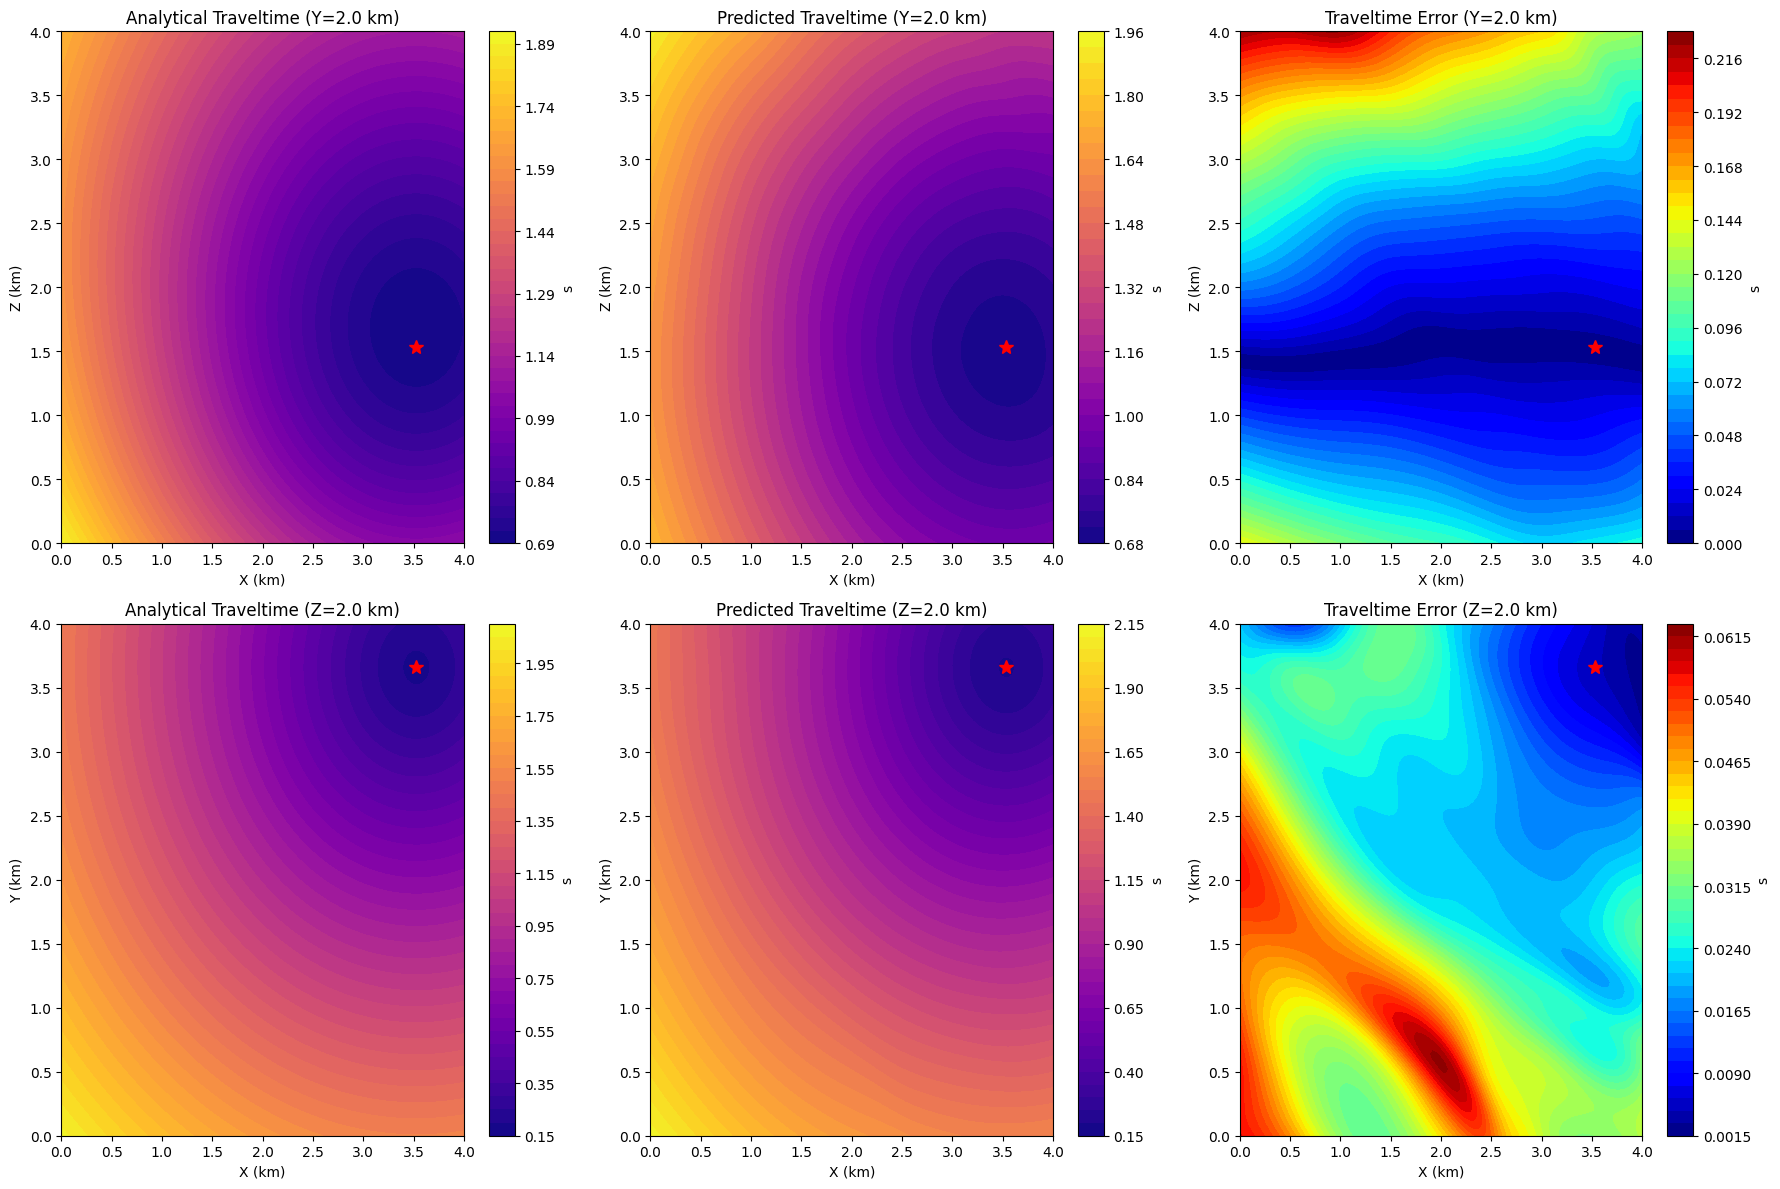

In [14]:

def plot_traveltime_comparison(pinn, sources, X, Y, Z, v0, vertgrad, 
                               y_slice_idx=50, z_slice_idx=50):
    """
    Plot traveltime comparison in 2x3 grid format (Y and Z slices)
    
    Args:
        pinn: Trained PINN model
        sources: List of source coordinates
        X, Y, Z: 3D grid tensors
        v0: Base velocity (km/s)
        vertgrad: Vertical velocity gradient (s^{-1})
        y_slice_idx: Index for Y-slice (fixed Y position)
        z_slice_idx: Index for Z-slice (fixed Z depth)
    """
    device = X.device
    src = sources[0]  # Use first source
    x_np = X[:, 0, 0].cpu().numpy()
    y_np = Y[0, :, 0].cpu().numpy()
    z_np = Z[0, 0, :].cpu().numpy()
    
    # Preallocate arrays
    T_anal_np = np.zeros((X.shape[0], Y.shape[1], Z.shape[2]))
    T_pred_np = np.zeros_like(T_anal_np)
    
    # Compute full 3D traveltimes
    for k in range(Z.shape[2]):
        for j in range(Y.shape[1]):
            # Create coordinate slice
            coords_slice = torch.stack((
                X[:, j, k].flatten(),
                Y[:, j, k].flatten(),
                Z[:, j, k].flatten()
            ), dim=1)
            
            # Create source repeated array
            src_rep = src.repeat(coords_slice.shape[0], 1)
            input_pts = torch.cat([coords_slice, src_rep], dim=1).to(device)
            
            # Predict traveltime
            with torch.no_grad():
                u_pred = pinn.predict(input_pts)
                r = torch.norm(coords_slice - src_rep[:, :3], dim=1)
                v_ref = v0 + vertgrad * src[2]
                T0_val = r / v_ref
                T_pred = (T0_val * u_pred.squeeze()).cpu().numpy()
                T_pred_np[:, j, k] = T_pred
            
            # Analytical solution
            T_anal = analytical_traveltime(
                coords_slice[:, 0], coords_slice[:, 1], coords_slice[:, 2],
                src[0], src[1], src[2], v0, vertgrad
            ).cpu().numpy()
            T_anal_np[:, j, k] = T_anal

    # Create figure
    plt.figure(figsize=(18, 12))
    
    # True traveltime at Y-slice
    plt.subplot(2, 3, 1)
    plt.contourf(X[:, y_slice_idx, :].cpu().numpy(), 
                 Z[:, y_slice_idx, :].cpu().numpy(), 
                 T_anal_np[:, y_slice_idx, :], 40, cmap='plasma')
    plt.colorbar(label='s')
    plt.xlabel('X (km)')
    plt.ylabel('Z (km)')
    plt.title(f'Analytical Traveltime (Y={y_np[y_slice_idx]:.1f} km)')
    plt.plot(src[0].item(), src[2].item(), 'r*', markersize=10)
    
    # Predicted traveltime at Y-slice
    plt.subplot(2, 3, 2)
    plt.contourf(X[:, y_slice_idx, :].cpu().numpy(), 
                 Z[:, y_slice_idx, :].cpu().numpy(), 
                 T_pred_np[:, y_slice_idx, :], 40, cmap='plasma')
    plt.colorbar(label='s')
    plt.xlabel('X (km)')
    plt.ylabel('Z (km)')
    plt.title(f'Predicted Traveltime (Y={y_np[y_slice_idx]:.1f} km)')
    plt.plot(src[0].item(), src[2].item(), 'r*', markersize=10)
    
    # Traveltime error at Y-slice
    plt.subplot(2, 3, 3)
    error_tt = np.abs(T_pred_np[:, y_slice_idx, :] - T_anal_np[:, y_slice_idx, :])
    plt.contourf(X[:, y_slice_idx, :].cpu().numpy(), 
                 Z[:, y_slice_idx, :].cpu().numpy(), 
                 error_tt, 40, cmap='jet')
    plt.colorbar(label='s')
    plt.xlabel('X (km)')
    plt.ylabel('Z (km)')
    plt.title(f'Traveltime Error (Y={y_np[y_slice_idx]:.1f} km)')
    plt.plot(src[0].item(), src[2].item(), 'r*', markersize=10)
    
    # True traveltime at Z-slice
    plt.subplot(2, 3, 4)
    plt.contourf(X[:, :, z_slice_idx].cpu().numpy(), 
                 Y[:, :, z_slice_idx].cpu().numpy(), 
                 T_anal_np[:, :, z_slice_idx], 40, cmap='plasma')
    plt.colorbar(label='s')
    plt.xlabel('X (km)')
    plt.ylabel('Y (km)')
    plt.title(f'Analytical Traveltime (Z={z_np[z_slice_idx]:.1f} km)')
    plt.plot(src[0].item(), src[1].item(), 'r*', markersize=10)
    
    # Predicted traveltime at Z-slice
    plt.subplot(2, 3, 5)
    plt.contourf(X[:, :, z_slice_idx].cpu().numpy(), 
                 Y[:, :, z_slice_idx].cpu().numpy(), 
                 T_pred_np[:, :, z_slice_idx], 40, cmap='plasma')
    plt.colorbar(label='s')
    plt.xlabel('X (km)')
    plt.ylabel('Y (km)')
    plt.title(f'Predicted Traveltime (Z={z_np[z_slice_idx]:.1f} km)')
    plt.plot(src[0].item(), src[1].item(), 'r*', markersize=10)
    
    # Traveltime error at Z-slice
    plt.subplot(2, 3, 6)
    error_tt = np.abs(T_pred_np[:, :, z_slice_idx] - T_anal_np[:, :, z_slice_idx])
    plt.contourf(X[:, :, z_slice_idx].cpu().numpy(), 
                 Y[:, :, z_slice_idx].cpu().numpy(), 
                 error_tt, 40, cmap='jet')
    plt.colorbar(label='s')
    plt.xlabel('X (km)')
    plt.ylabel('Y (km)')
    plt.title(f'Traveltime Error (Z={z_np[z_slice_idx]:.1f} km)')
    plt.plot(src[0].item(), src[1].item(), 'r*', markersize=10)
    
    plt.tight_layout()
    plt.savefig("pinn3d02__3d_traveltime_comparison.png", dpi=300)
    plt.show()

# Add after training completion
plot_traveltime_comparison(pinn, sources, X, Y, Z, v0, vertgrad,
                           y_slice_idx=50,  # Middle of Y-axis
                           z_slice_idx=50)  # Middle of Z-axis

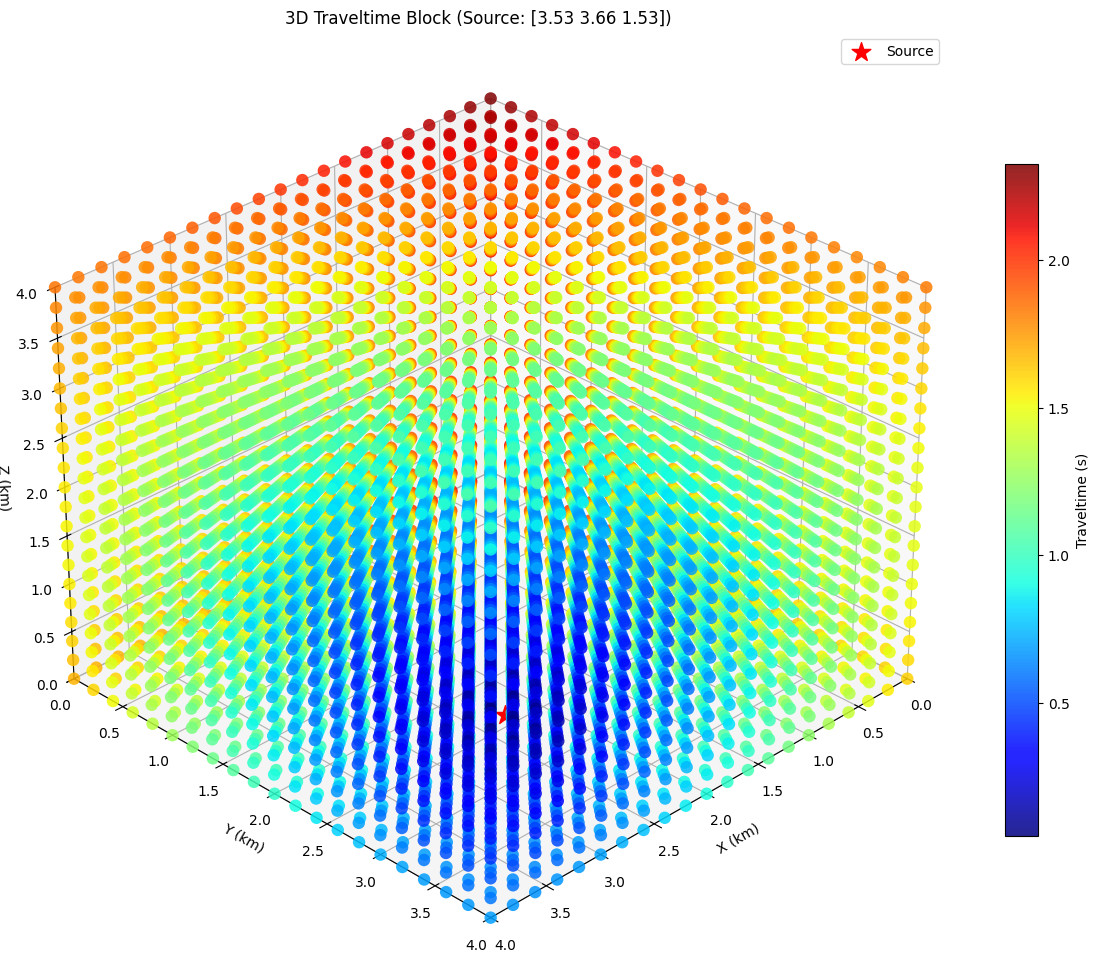

In [19]:
def plot_3d_traveltime_block(pinn, src, X, Y, Z, v0, vertgrad, step=5, cmap='jet'):
    """
    Plot 3D traveltime block using volumetric visualization with sampling
    
    Args:
        pinn: Trained PINN model
        src: Source coordinates tensor (3 elements)
        X, Y, Z: 3D grid coordinate tensors
        v0: Base velocity (km/s)
        vertgrad: Vertical velocity gradient (s^{-1})
        step: Sampling step size (reduce grid density)
        cmap: Colormap for traveltimes
    """
    # Downsample grid using step size
    x_ds = X[::step, ::step, ::step].flatten()
    y_ds = Y[::step, ::step, ::step].flatten()
    z_ds = Z[::step, ::step, ::step].flatten()
    
    coords_ds = torch.stack((x_ds, y_ds, z_ds), dim=1)
    src_rep = src.repeat(coords_ds.shape[0], 1)
    input_pts = torch.cat([coords_ds, src_rep], dim=1).to(device)
    
    # Predict traveltimes
    with torch.no_grad():
        u_pred = pinn.predict(input_pts)
        r = torch.norm(coords_ds - src_rep[:, :3], dim=1)
        v_ref = v0 + vertgrad * src[2]
        T0_val = r / v_ref
        T_pred = (T0_val * u_pred.squeeze()).cpu().numpy()
    
    # Convert to numpy arrays
    x_np = x_ds.cpu().numpy()
    y_np = y_ds.cpu().numpy()
    z_np = z_ds.cpu().numpy()
    
    # Create figure
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Create scatter plot with color mapping
    sc = ax.scatter(
        x_np, y_np, z_np, 
        c=T_pred, 
        cmap=cmap,
        alpha=0.85,
        s=80,  # Point size
        edgecolors='none'
    )
    
    # Plot source point
    src_np = src.cpu().numpy()
    ax.scatter([src_np[0]], [src_np[1]], [src_np[2]], 
               s=200, c='red', marker='*', label='Source')
    
    # Configure plot
    ax.set_xlabel('X (km)')
    ax.set_ylabel('Y (km)')
    ax.set_zlabel('Z (km)')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_zlim(z_min, z_max)
    ax.set_title(f'3D Traveltime Block (Source: {src_np.round(2)})')
    
    # Add colorbar
    cbar = fig.colorbar(sc, ax=ax, shrink=0.7, aspect=20)
    cbar.set_label('Traveltime (s)')
    
    # Add legend
    ax.legend()
    
    # Set viewing angle
    ax.view_init(elev=30, azim=45)
    
    plt.tight_layout()
    plt.savefig("pinn3d02_3d_traveltime_block.png")
    plt.show()

# Usage example
src0 = sources[0]  # First source
plot_3d_traveltime_block(pinn, src0, X, Y, Z, v0, vertgrad, step=5)

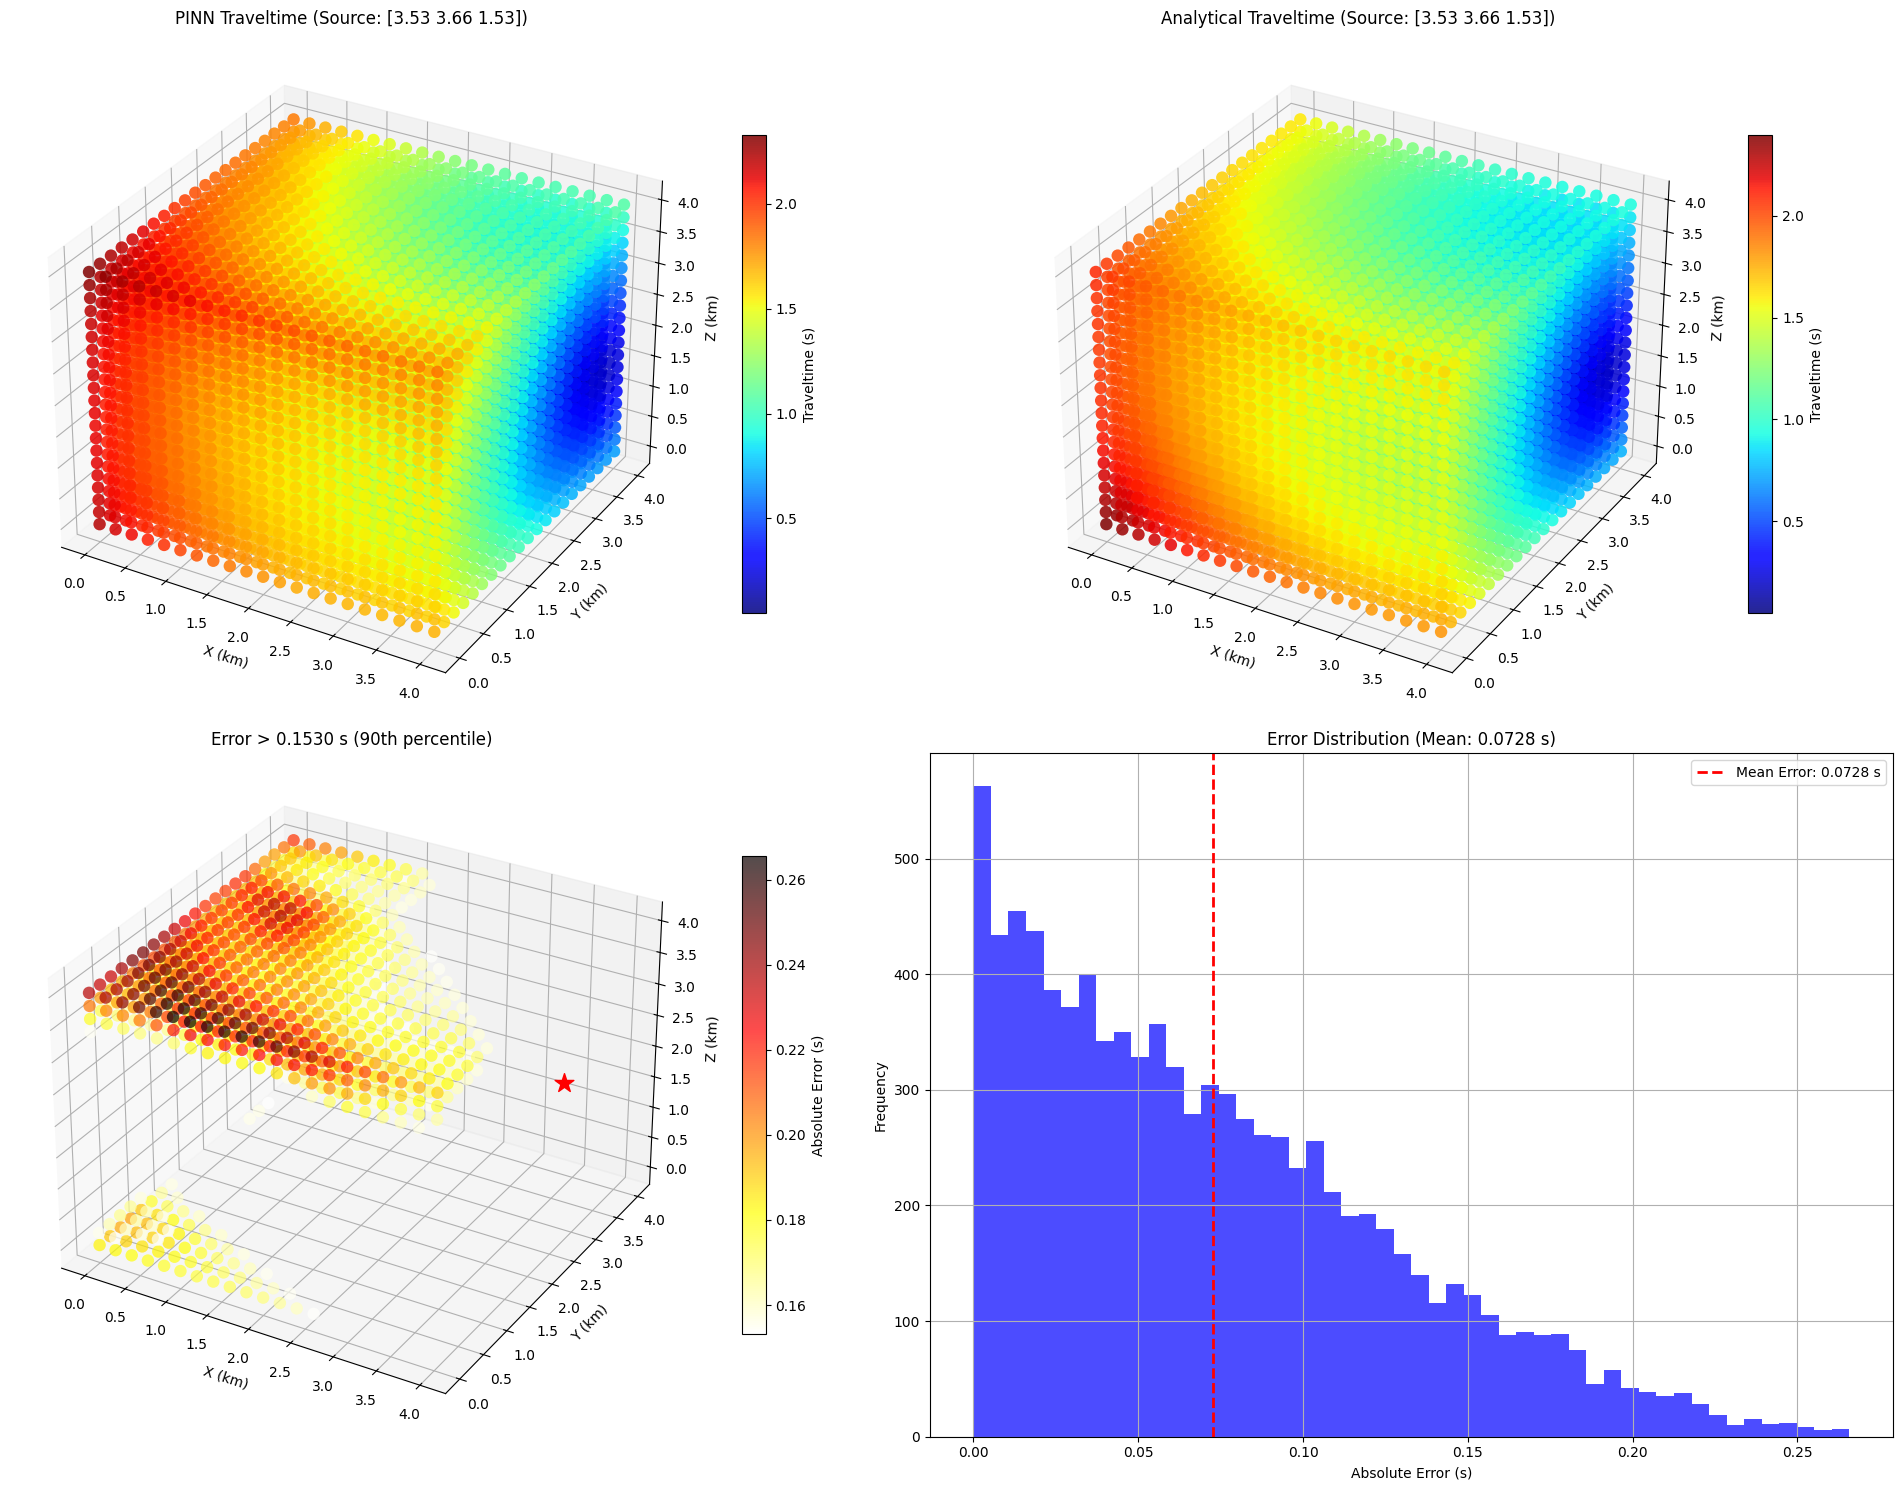


Traveltime Error Analysis:
Mean Absolute Error: 0.072826 s
Max Absolute Error: 0.265676 s
RMS Error: 0.091409 s
90th Percentile Threshold: 0.153046 s


In [25]:
def plot_3d_traveltime_block(pinn, src, X, Y, Z, v0, vertgrad, step=5, cmap='jet'):
    """
    Plot 3D traveltime block using volumetric visualization with sampling,
    including analytical solution and error analysis
    
    Args:
        pinn: Trained PINN model
        src: Source coordinates tensor (3 elements)
        X, Y, Z: 3D grid coordinate tensors
        v0: Base velocity (km/s)
        vertgrad: Vertical velocity gradient (s^{-1})
        step: Sampling step size (reduce grid density)
        cmap: Colormap for traveltimes
    """
    # Downsample grid using step size
    x_ds = X[::step, ::step, ::step].flatten()
    y_ds = Y[::step, ::step, ::step].flatten()
    z_ds = Z[::step, ::step, ::step].flatten()
    
    coords_ds = torch.stack((x_ds, y_ds, z_ds), dim=1)
    src_rep = src.repeat(coords_ds.shape[0], 1)
    input_pts = torch.cat([coords_ds, src_rep], dim=1).to(device)
    
    # Predict traveltimes
    with torch.no_grad():
        u_pred = pinn.predict(input_pts)
        r = torch.norm(coords_ds - src_rep[:, :3], dim=1)
        v_ref = v0 + vertgrad * src[2]
        T0_val = r / v_ref
        T_pred = (T0_val * u_pred.squeeze()).cpu().numpy()
    
    # Compute analytical traveltimes
    T_anal = analytical_traveltime(
        coords_ds[:, 0], coords_ds[:, 1], coords_ds[:, 2],
        src[0], src[1], src[2], v0, vertgrad
    ).cpu().numpy()
    
    # Convert to numpy arrays
    x_np = x_ds.cpu().numpy()
    y_np = y_ds.cpu().numpy()
    z_np = z_ds.cpu().numpy()
    
    # Create figure with subplots
    fig = plt.figure(figsize=(20, 15))
    
    # 1. PINN Prediction Plot
    ax1 = fig.add_subplot(221, projection='3d')
    sc1 = ax1.scatter(
        x_np, y_np, z_np, 
        c=T_pred, 
        cmap=cmap,
        alpha=0.85,
        s=80,
        edgecolors='none'
    )
    ax1.scatter([src[0]], [src[1]], [src[2]], 
               s=200, c='red', marker='*', label='Source')
    ax1.set_title(f'PINN Traveltime (Source: {src.cpu().numpy().round(2)})')
    ax1.set_xlabel('X (km)')
    ax1.set_ylabel('Y (km)')
    ax1.set_zlabel('Z (km)')
    fig.colorbar(sc1, ax=ax1, shrink=0.7, aspect=20, label='Traveltime (s)')
    
    # 2. Analytical Solution Plot
    ax2 = fig.add_subplot(222, projection='3d')
    sc2 = ax2.scatter(
        x_np, y_np, z_np, 
        c=T_anal, 
        cmap=cmap,
        alpha=0.85,
        s=80,
        edgecolors='none'
    )
    ax2.scatter([src[0]], [src[1]], [src[2]], 
               s=200, c='red', marker='*', label='Source')
    ax2.set_title(f'Analytical Traveltime (Source: {src.cpu().numpy().round(2)})')
    ax2.set_xlabel('X (km)')
    ax2.set_ylabel('Y (km)')
    ax2.set_zlabel('Z (km)')
    fig.colorbar(sc2, ax=ax2, shrink=0.7, aspect=20, label='Traveltime (s)')
    
    # 3. Error Visualization
    abs_error = np.abs(T_pred - T_anal)
    ax3 = fig.add_subplot(223, projection='3d')
    error_threshold = np.percentile(abs_error, 90)  # Top 10% errors
    error_mask = abs_error > error_threshold
    
    sc3 = ax3.scatter(
        x_np[error_mask], y_np[error_mask], z_np[error_mask], 
        c=abs_error[error_mask], 
        cmap='hot_r',
        alpha=0.7,
        s=80,
        edgecolors='none'
    )
    ax3.scatter([src[0]], [src[1]], [src[2]], 
               s=200, c='red', marker='*', label='Source')
    ax3.set_title(f'Error > {error_threshold:.4f} s (90th percentile)')
    ax3.set_xlabel('X (km)')
    ax3.set_ylabel('Y (km)')
    ax3.set_zlabel('Z (km)')
    fig.colorbar(sc3, ax=ax3, shrink=0.7, aspect=20, label='Absolute Error (s)')
    
    # 4. Error Histogram
    ax4 = fig.add_subplot(224)
    ax4.hist(abs_error, bins=50, alpha=0.7, color='blue')
    mean_error = np.mean(abs_error)
    ax4.axvline(mean_error, color='r', linestyle='dashed', linewidth=2)
    ax4.set_xlabel('Absolute Error (s)')
    ax4.set_ylabel('Frequency')
    ax4.set_title(f'Error Distribution (Mean: {mean_error:.4f} s)')
    ax4.grid(True)
    ax4.legend([f'Mean Error: {mean_error:.4f} s'])
    
    plt.tight_layout()
    plt.savefig("pinn3d20_3d_traveltime_comparison.png", dpi=300)
    plt.show()
    
    # Print error metrics
    max_error = np.max(abs_error)
    rms_error = np.sqrt(np.mean(abs_error**2))
    print("\nTraveltime Error Analysis:")
    print(f"Mean Absolute Error: {mean_error:.6f} s")
    print(f"Max Absolute Error: {max_error:.6f} s")
    print(f"RMS Error: {rms_error:.6f} s")
    print(f"90th Percentile Threshold: {error_threshold:.6f} s")

# Usage example
src0 = sources[0]  # First source
plot_3d_traveltime_block(pinn, src0, X, Y, Z, v0, vertgrad, step=5)

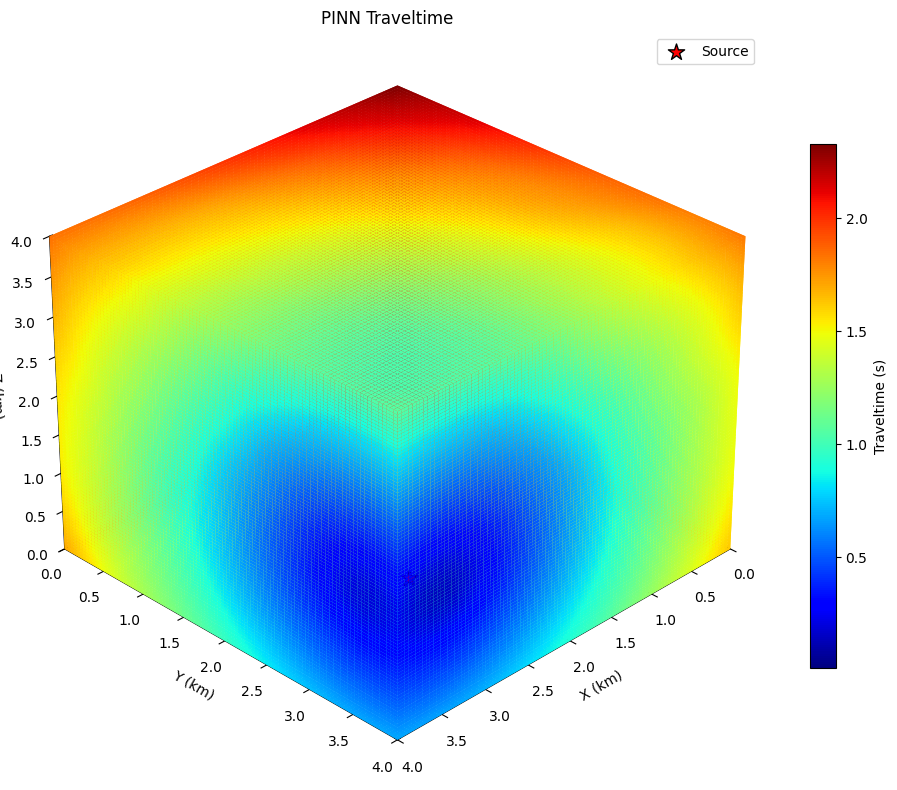

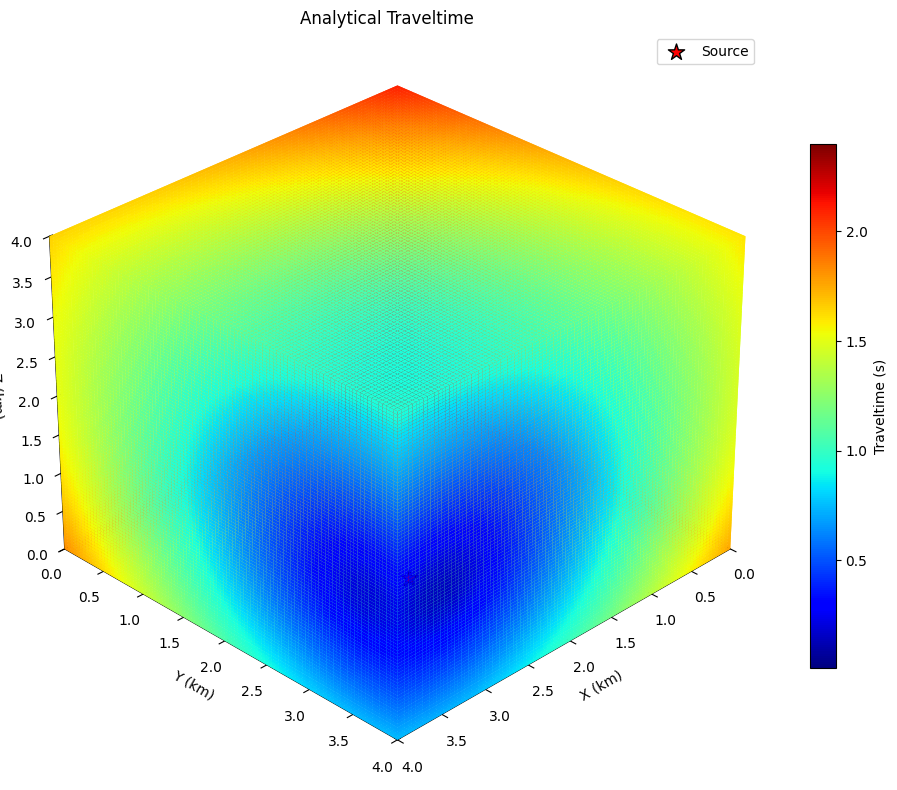

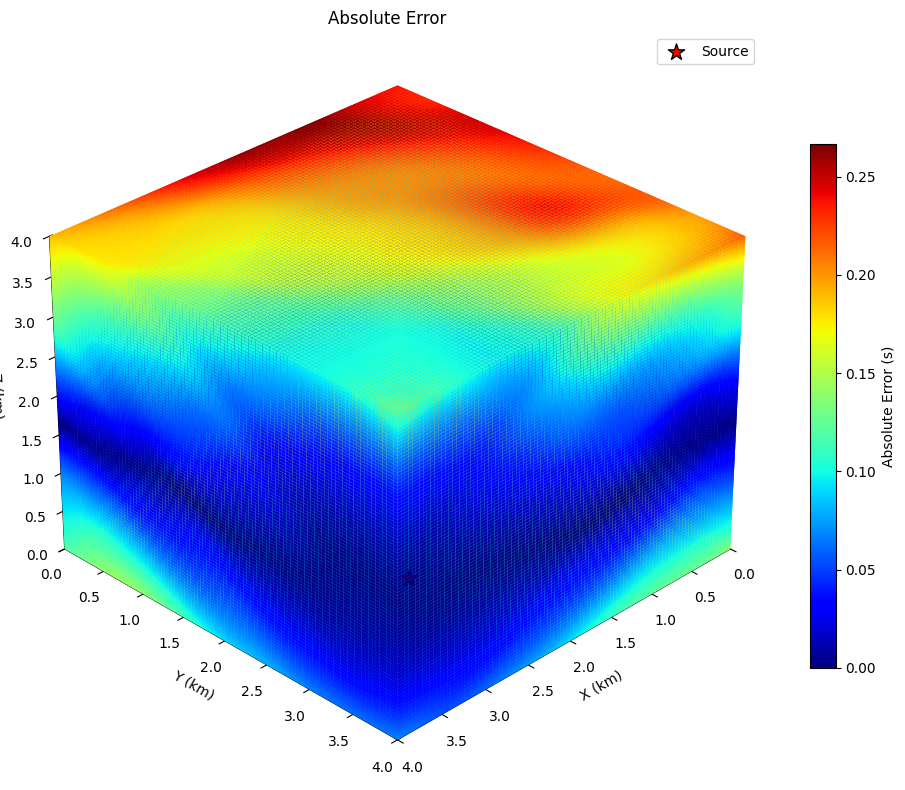

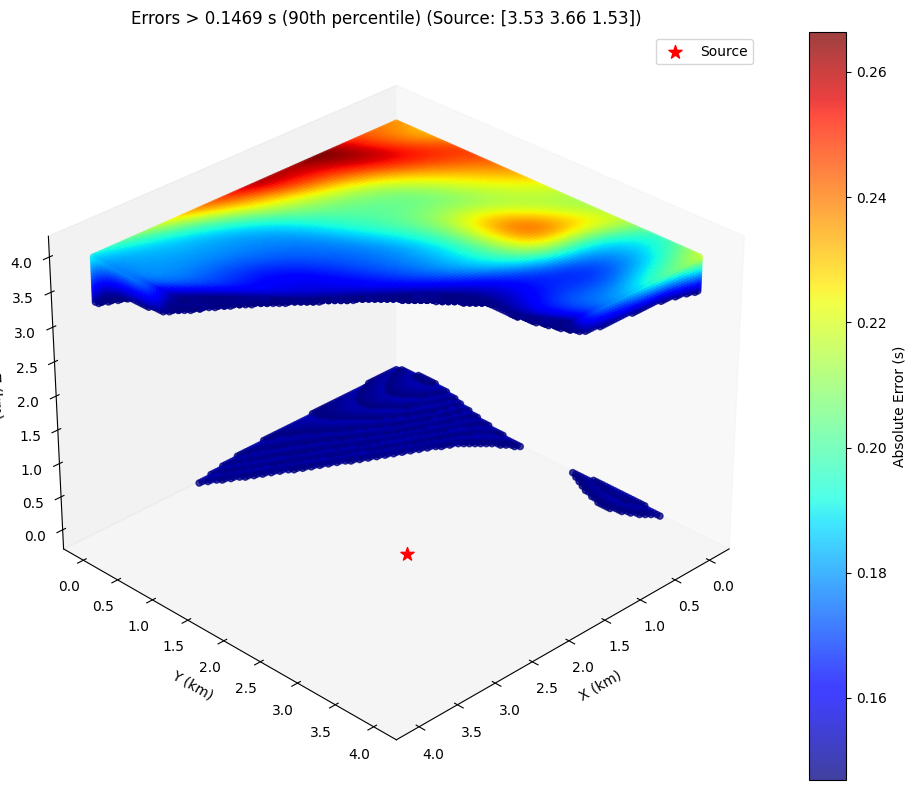


Traveltime Error Analysis:
Mean Absolute Error: 0.069415 s
Max Absolute Error: 0.266318 s
RMS Error: 0.087184 s
90th Percentile Threshold: 0.146894 s


In [23]:
def plot_3d_traveltime_comparison(pinn, src, X, Y, Z, v0, vertgrad, 
                                  num_slices=8, alpha=0.25, cmap='jet'):
    """
    Visualize PINN and analytical traveltimes as 3D volumes with slices,
    and include error analysis
    
    Args:
        pinn: Trained PINN model
        src: Source coordinates tensor (3 elements)
        X, Y, Z: 3D grid coordinate tensors
        v0: Base velocity (km/s)
        vertgrad: Vertical velocity gradient (s^{-1})
        num_slices: Number of slices in each direction
        alpha: Transparency level (0-1)
        cmap: Colormap for traveltimes
    """
    device = X.device
    nx, ny, nz = X.shape
    src_np = src.cpu().numpy()
    
    # Preallocate arrays
    T_pred = np.zeros((nx, ny, nz))
    T_anal = np.zeros((nx, ny, nz))
    
    # Compute full 3D traveltimes for PINN and analytical
    for k in range(nz):
        for j in range(ny):
            # Create coordinate slice
            coords_slice = torch.stack((
                X[:, j, k].flatten(),
                Y[:, j, k].flatten(),
                Z[:, j, k].flatten()
            ), dim=1)
            
            # Create source repeated array
            src_rep = src.repeat(coords_slice.shape[0], 1)
            input_pts = torch.cat([coords_slice, src_rep], dim=1).to(device)
            
            # Predict traveltime with PINN
            with torch.no_grad():
                u_pred = pinn.predict(input_pts)
                r = torch.norm(coords_slice - src_rep[:, :3], dim=1)
                v_ref = v0 + vertgrad * src[2]
                T0_val = r / v_ref
                T_pred_slice = (T0_val * u_pred.squeeze()).cpu().numpy()
                T_pred[:, j, k] = T_pred_slice
            
            # Compute analytical traveltime
            x_vals = coords_slice[:, 0]
            y_vals = coords_slice[:, 1]
            z_vals = coords_slice[:, 2]
            T_anal_slice = analytical_traveltime(
                x_vals, y_vals, z_vals,
                src[0], src[1], src[2], v0, vertgrad
            ).cpu().numpy()
            T_anal[:, j, k] = T_anal_slice
    
    # Compute error metrics
    abs_error = np.abs(T_pred - T_anal)
    max_error = np.max(abs_error)
    mean_error = np.mean(abs_error)
    rms_error = np.sqrt(np.mean(abs_error**2))
    error_threshold = np.percentile(abs_error, 90)  # 90th percentile
    
    # Convert grid to numpy
    x_np = X[:, 0, 0].cpu().numpy()
    y_np = Y[0, :, 0].cpu().numpy()
    z_np = Z[0, 0, :].cpu().numpy()
    
    # Standard figure size for all plots
    figsize = (10, 8)
    elev = 30
    azim = 45
    
    # 1. PINN Traveltime Volume
    fig1 = plt.figure(figsize=figsize)
    ax1 = fig1.add_subplot(111, projection='3d')
    plot_3d_slices(ax1, T_pred, x_np, y_np, z_np, src_np, 
                   num_slices, alpha, cmap, 
                   vmin=np.min(T_pred), vmax=np.max(T_pred),
                   title='PINN Traveltime')
    ax1.view_init(elev=elev, azim=azim)
    plt.tight_layout()
    plt.savefig("pinn3d20_traveltime_volume.png", dpi=300)
    plt.show()
    
    # 2. Analytical Traveltime Volume
    fig2 = plt.figure(figsize=figsize)
    ax2 = fig2.add_subplot(111, projection='3d')
    plot_3d_slices(ax2, T_anal, x_np, y_np, z_np, src_np, 
                   num_slices, alpha, cmap, 
                   vmin=np.min(T_anal), vmax=np.max(T_anal),
                   title='Analytical Traveltime')
    ax2.view_init(elev=elev, azim=azim)
    plt.tight_layout()
    plt.savefig("pinn3d20_analytical_traveltime_volume.png", dpi=300)
    plt.show()
    
    # 3. Error Volume
    fig3 = plt.figure(figsize=figsize)
    ax3 = fig3.add_subplot(111, projection='3d')
    plot_3d_slices(ax3, abs_error, x_np, y_np, z_np, src_np, 
                   num_slices, alpha, 'jet', 
                   vmin=0, vmax=max_error,
                   title='Absolute Error')
    ax3.view_init(elev=elev, azim=azim)
    plt.tight_layout()
    plt.savefig("pinn3d20_traveltime_error_volume.png", dpi=300)
    plt.show()
    
    # 4. Significant Error Points
    fig4 = plt.figure(figsize=figsize)
    ax4 = fig4.add_subplot(111, projection='3d')
    error_mask = abs_error > error_threshold
    coords = np.stack(np.where(error_mask), axis=1)
    if len(coords) > 0:
        # Only plot if there are significant errors
        x_err = x_np[coords[:, 0]]
        y_err = y_np[coords[:, 1]]
        z_err = z_np[coords[:, 2]]
        errors = abs_error[error_mask]
        
        sc = ax4.scatter(
            x_err, y_err, z_err, c=errors, 
            cmap='jet', alpha=0.75, s=20
        )
        plt.colorbar(sc, ax=ax4, label='Absolute Error (s)')
    ax4.scatter([src_np[0]], [src_np[1]], [src_np[2]], 
               s=100, c='red', marker='*', label='Source')
    ax4.set_title(f'Errors > {error_threshold:.4f} s (90th percentile) (Source: {src.cpu().numpy().round(2)})')
    ax4.view_init(elev=elev, azim=azim)
    ax4.set_xlabel('X (km)')
    ax4.set_ylabel('Y (km)')
    ax4.set_zlabel('Z (km)')
    ax4.legend()
    ax4.grid(False)
    plt.tight_layout()
    plt.savefig("pinn3d20_significant_error_volume.png", dpi=300)
    plt.show()
    
    # Print error metrics
    print("\nTraveltime Error Analysis:")
    print(f"Mean Absolute Error: {mean_error:.6f} s")
    print(f"Max Absolute Error: {max_error:.6f} s")
    print(f"RMS Error: {rms_error:.6f} s")
    print(f"90th Percentile Threshold: {error_threshold:.6f} s")

def plot_3d_slices(ax, data, x_np, y_np, z_np, src_np, 
                   num_slices, alpha, cmap, vmin, vmax, title):
    """Helper function to plot 3D slices for a volume"""
    # Set up plot
    ax.grid(False)
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.set_facecolor('none')
    
    # Create colormap and normalization
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    cmap_func = plt.get_cmap(cmap)
    
    # Create slices in X direction
    x_slices = np.linspace(x_np.min(), x_np.max(), num_slices)
    for x_val in x_slices:
        x_idx = np.abs(x_np - x_val).argmin()
        Y_surf, Z_surf = np.meshgrid(y_np, z_np, indexing='ij')
        X_surf = np.full_like(Y_surf, x_val)
        T_slice = data[x_idx, :, :]
        ax.plot_surface(X_surf, Y_surf, Z_surf, 
                        facecolors=cmap_func(norm(T_slice)),
                        rstride=1, cstride=1, alpha=alpha,
                        shade=False, edgecolor='none')
    
    # Create slices in Y direction
    y_slices = np.linspace(y_np.min(), y_np.max(), num_slices)
    for y_val in y_slices:
        y_idx = np.abs(y_np - y_val).argmin()
        X_surf, Z_surf = np.meshgrid(x_np, z_np, indexing='ij')
        Y_surf = np.full_like(X_surf, y_val)
        T_slice = data[:, y_idx, :]
        ax.plot_surface(X_surf, Y_surf, Z_surf, 
                        facecolors=cmap_func(norm(T_slice)),
                        rstride=1, cstride=1, alpha=alpha,
                        shade=False, edgecolor='none')
    
    # Create slices in Z direction
    z_slices = np.linspace(z_np.min(), z_np.max(), num_slices)
    for z_val in z_slices:
        z_idx = np.abs(z_np - z_val).argmin()
        X_surf, Y_surf = np.meshgrid(x_np, y_np, indexing='ij')
        Z_surf = np.full_like(X_surf, z_val)
        T_slice = data[:, :, z_idx]
        ax.plot_surface(X_surf, Y_surf, Z_surf, 
                        facecolors=cmap_func(norm(T_slice)),
                        rstride=1, cstride=1, alpha=alpha,
                        shade=False, edgecolor='none')
    
    # Plot source point
    ax.scatter([src_np[0]], [src_np[1]], [src_np[2]], 
               s=150, c='red', marker='*', label='Source', edgecolors='black')
    
    # Configure plot
    ax.set_xlabel('X (km)')
    ax.set_ylabel('Y (km)')
    ax.set_zlabel('Z (km)')
    ax.set_xlim(x_np.min(), x_np.max())
    ax.set_ylim(y_np.min(), y_np.max())
    ax.set_zlim(z_np.min(), z_np.max())
    
    # Add colorbar
    mappable = plt.cm.ScalarMappable(norm=norm, cmap=cmap_func)
    mappable.set_array(data)
    cbar = plt.colorbar(mappable, ax=ax, shrink=0.7, aspect=20)
    cbar.set_label('Traveltime (s)' if 'Error' not in title else 'Absolute Error (s)')
    
    ax.set_title(title)
    ax.legend(loc='upper right')

# Usage example
src0 = sources[0]  # First source
plot_3d_traveltime_comparison(pinn, src0, X, Y, Z, v0, vertgrad,
                              num_slices=2, alpha=1.0)

C:\Users\user\AppData\Local\Temp\ipykernel_75796\2610639133.py:138: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig("pinn_3d20_traveltime_error.png", dpi=300)


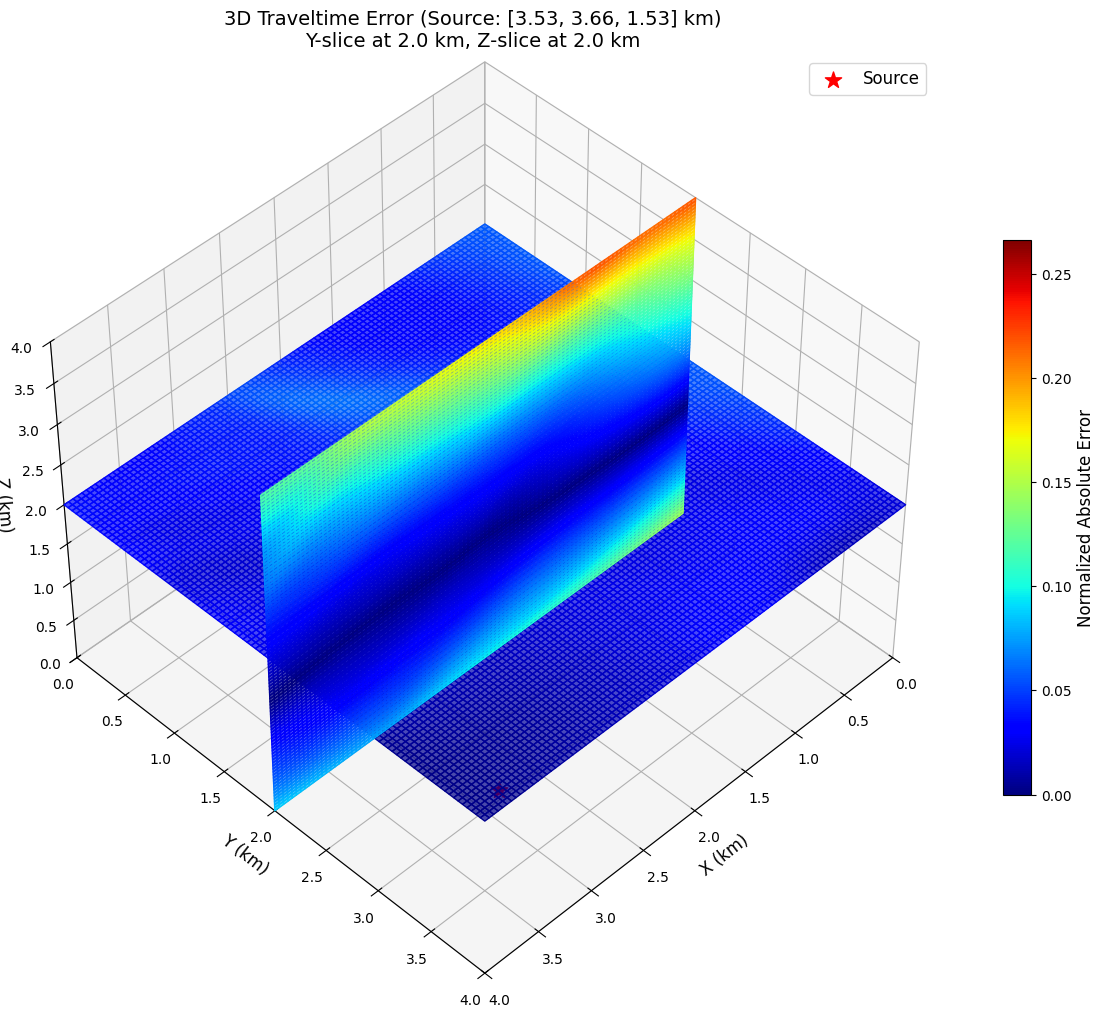

In [24]:

def plot_3d_traveltime_error(pinn, sources, X, Y, Z, v0, vertgrad, 
                             src_idx=0, y_slice_idx=None, z_slice_idx=None):
    """
    Plot 3D traveltime error combining Y-slice and Z-slice views
    
    Args:
        pinn: Trained PINN model
        sources: List of source coordinates
        X, Y, Z: 3D grid tensors
        v0: Base velocity (km/s)
        vertgrad: Vertical velocity gradient (s^{-1})
        src_idx: Index of source to visualize
        y_slice_idx: Index for Y-slice (if None, use middle index)
        z_slice_idx: Index for Z-slice (if None, use middle index)
    """
    device = X.device
    src = sources[src_idx]
    nx, ny, nz = X.shape
    
    # Set default slice indices if not provided
    if y_slice_idx is None:
        y_slice_idx = ny // 2
    if z_slice_idx is None:
        z_slice_idx = nz // 2
        
    # Convert grid to numpy for plotting
    X_np = X.cpu().numpy()
    Y_np = Y.cpu().numpy()
    Z_np = Z.cpu().numpy()
    
    # Preallocate arrays
    T_pred = np.zeros((nx, ny, nz))
    T_anal = np.zeros_like(T_pred)
    
    # Compute full 3D traveltimes
    for k in range(nz):
        for j in range(ny):
            # Create coordinate slice
            coords_slice = torch.stack((
                X[:, j, k].flatten(),
                Y[:, j, k].flatten(),
                Z[:, j, k].flatten()
            ), dim=1)
            
            # Create source repeated array
            src_rep = src.repeat(coords_slice.shape[0], 1)
            input_pts = torch.cat([coords_slice, src_rep], dim=1).to(device)
            
            # Predict traveltime
            with torch.no_grad():
                u_pred = pinn.predict(input_pts)
                r = torch.norm(coords_slice - src_rep[:, :3], dim=1)
                v_ref = v0 + vertgrad * src[2]
                T0_val = r / v_ref
                T_pred_slice = (T0_val * u_pred.squeeze()).cpu().numpy()
                T_pred[:, j, k] = T_pred_slice
            
            # Analytical solution
            T_anal_slice = analytical_traveltime(
                coords_slice[:, 0], coords_slice[:, 1], coords_slice[:, 2],
                src[0], src[1], src[2], v0, vertgrad
            ).cpu().numpy()
            T_anal[:, j, k] = T_anal_slice
    
    # Calculate absolute error
    error = np.abs(T_pred - T_anal)
    
    # Get slice values
    Y_slice = Y_np[0, y_slice_idx, 0]  # Y value for the slice
    Z_slice = Z_np[0, 0, z_slice_idx]  # Z value for the slice
    src_x, src_y, src_z = src[0].item(), src[1].item(), src[2].item()
    
    # Create figure
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Prepare Y-slice data (X-Z plane at fixed Y)
    X_vals = X_np[:, 0, 0]
    Z_vals = Z_np[0, 0, :]
    X_y, Z_y = np.meshgrid(X_vals, Z_vals, indexing='ij')
    error_y = error[:, y_slice_idx, :]
    
    # Plot Y-slice
    ax.plot_surface(
        X_y, 
        np.full_like(X_y, Y_slice), 
        Z_y,
        facecolors=plt.cm.jet(error_y / np.max(error)),
        rstride=1, cstride=1,
        alpha=0.7, antialiased=True,
        shade=False
    )
    
    # Prepare Z-slice data (X-Y plane at fixed Z)
    Y_vals = Y_np[0, :, 0]
    X_z, Y_z = np.meshgrid(X_vals, Y_vals, indexing='ij')
    error_z = error[:, :, z_slice_idx]
    
    # Plot Z-slice
    ax.plot_surface(
        X_z, 
        Y_z,
        np.full_like(X_z, Z_slice),
        facecolors=plt.cm.jet(error_z / np.max(error)),
        rstride=1, cstride=1,
        alpha=0.7, antialiased=True,
        shade=False
    )
    
    # Plot source location
    ax.scatter([src_x], [src_y], [src_z], 
               s=150, c='red', marker='*', label='Source')
    
    # Configure plot
    ax.set_xlabel('X (km)', fontsize=12)
    ax.set_ylabel('Y (km)', fontsize=12)
    ax.set_zlabel('Z (km)', fontsize=12)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_zlim(z_min, z_max)
    ax.set_title(f'3D Traveltime Error (Source: [{src_x:.2f}, {src_y:.2f}, {src_z:.2f}] km)\n'
                 f'Y-slice at {Y_slice:.1f} km, Z-slice at {Z_slice:.1f} km',
                 fontsize=14)
    
    # Add colorbar
    mappable = plt.cm.ScalarMappable(cmap=plt.cm.jet)
    mappable.set_array(error)
    cbar = fig.colorbar(mappable, ax=ax, shrink=0.6, aspect=20)
    cbar.set_label('Normalized Absolute Error', fontsize=12)
    
    # Add legend
    ax.legend(fontsize=12)
    
    # Adjust viewing angle
    ax.view_init(elev=45, azim=45)
    
    plt.tight_layout()
    plt.savefig("pinn_3d20_traveltime_error.png", dpi=300)
    plt.show()

# Add after training completion
plot_3d_traveltime_error(pinn, sources, X, Y, Z, v0, vertgrad,
                         src_idx=0,  # First source
                         y_slice_idx=50,  # Middle of Y-axis
                         z_slice_idx=50)  # Middle of Z-axis